# Load Data

In [1]:
import pandas as pd

# 데이터프레임으로 변환
laliga_train = pd.read_csv("../csv/LaLiga/train_La.csv")
# print(laliga_train.info())

In [2]:
# Drop index column
laliga_train = laliga_train.drop(['Rk'], axis=1)
# print(laliga_train.info())

In [3]:
import numpy as np
# print(np.unique(laliga_train['Pos'].values))

replace_values = {
    'DF,FW': 'FW,DF',
    'DF,MF': 'MF,DF',
    'MF,FW': 'FW,MF'
}

laliga_train['Pos'] = laliga_train['Pos'].replace(replace_values)
# print(np.unique(laliga_train['Pos'].values))

# 결측치 채우기

In [4]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

numeric_laliga_train = laliga_train.select_dtypes(include=[np.number])
column_names = numeric_laliga_train.columns

imputer.fit(numeric_laliga_train)
numeric_laliga_train = imputer.transform(numeric_laliga_train)

numeric_laliga_train_df = pd.DataFrame(numeric_laliga_train, columns=column_names)

laliga_train[column_names] = numeric_laliga_train_df.round(2)

# 열 별로 NaN 값이 있는지 확인
column_nan = laliga_train.isna().any()
print(len(column_nan))
print(column_nan)

# laliga_train.info()

47
Player     False
Nation     False
Pos        False
Squad      False
Age        False
Born       False
90s        False
Gls        False
Sh         False
SoT        False
SoT%       False
Sh/90      False
SoT/90     False
G/Sh       False
G/SoT      False
Dist       False
FK         False
PK         False
PKatt      False
xG         False
npxG       False
npxG/Sh    False
G-xG       False
np:G-xG    False
Matches    False
Cmp        False
Att        False
Cmp%       False
TotDist    False
PrgDist    False
Ast        False
xAG        False
xA         False
A-xAG      False
KP         False
1/3        False
PPA        False
CrsPA      False
PrgP       False
Won        False
Lost       False
Won%       False
Tkl        False
TklW       False
Def 3rd    False
Mid 3rd    False
Att 3rd    False
dtype: bool


# 수비 지표 점수 계산

In [5]:
from sklearn.preprocessing import StandardScaler

# 가중치 설정
weights = {
    'Won': 1.0,
    'Lost': 0,
    'Won%': 1.5,
    'Tkl': 1.2,
    'TklW': 1.8,
    'Def 3rd': 1.5,
    'Mid 3rd': 1.0,
    'Att 3rd': 0.8
}

# 정규화
scaler = StandardScaler()
scaled_features = scaler.fit_transform(laliga_train[list(weights.keys())])
scaled_df = pd.DataFrame(scaled_features, columns=weights.keys())

# 종합 점수 계산
laliga_train['Defensive Score'] = (
    scaled_df['Won'] * weights['Won'] +
    scaled_df['Lost'] * weights['Lost'] +
    scaled_df['Won%'] * weights['Won%'] +
    scaled_df['Tkl'] * weights['Tkl'] +
    scaled_df['TklW'] * weights['TklW'] +
    scaled_df['Def 3rd'] * weights['Def 3rd'] +
    scaled_df['Mid 3rd'] * weights['Mid 3rd'] +
    scaled_df['Att 3rd'] * weights['Att 3rd']
)

# print(laliga_train[['Player', 'Defensive Score']])

In [ ]:
# top_score = laliga_train['Defensive Score'].max()
# laliga_train.loc[laliga_train['Defensive Score'].idxmax(), 'Player']

# Define X, y & Encode

In [6]:
import category_encoders as ce

X = laliga_train.drop(columns=['Player', 'Won', 'Lost', 'Won%', 'Tkl', 'TklW', 'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Defensive Score'])
# X = laliga_train.drop(columns=['Player','Defensive Score'])
y = laliga_train['Defensive Score']

target_encoder = ce.TargetEncoder(cols=['Nation', 'Pos', 'Squad', 'Matches'])

# 인코딩 수행
laliga_train_encoded = target_encoder.fit_transform(X, y)
# 데이터프레임 재구성
laliga_train_encoded['Defensive Score'] = laliga_train['Defensive Score']

X_encoded_train = laliga_train_encoded.drop(columns=['Defensive Score'], axis=1)
y_encoded_train = laliga_train_encoded['Defensive Score']

# Descriptive Statistics

In [ ]:
# print(y_encoded_train.describe())

In [7]:
y_binned = pd.qcut(y_encoded_train, q=5, labels=False, duplicates='drop')
print(pd.Series(y_binned).value_counts())

Defensive Score
1    586
0    582
4    582
3    581
2    577
Name: count, dtype: int64


# Train / Validate / Test Split

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_val_test, y_train, y_val_test = train_test_split(
    X_encoded_train, y_encoded_train,
    test_size=0.3,
    random_state=42,
    shuffle=True,
)

X_val, X_test, y_val, y_test = train_test_split(
    X_val_test, y_val_test,
    test_size=0.5,
    random_state=42,
)

# 1st Random Forest Regressor

In [ ]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import KFold, GridSearchCV
# from joblib import dump, load
# 
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# 
# random_forest = RandomForestRegressor(n_jobs=-1)
# 
# rf_params = {
#     'random_state': [42],
#     'n_estimators': [50, 100, 150, 200],
#     'max_depth': [3, 5, 7],
#     'max_features': ['sqrt', 'log2', 0.7, 0.9, None],
#     'min_samples_leaf': [3, 5, 7, 9, 11],
#     'ccp_alpha': [0.3, 0.5, 0.7, 0.9]
# }
# 
# gs = GridSearchCV(
#     estimator=random_forest,
#     param_grid=rf_params,
#     scoring='neg_root_mean_squared_error',
#     cv= kf
# )
# 
# gs.fit(X_train, y_train)
# 
# # 최적의 모델을 파일로 저장
# dump(gs.best_estimator_, 'top_defender_model_ver1.joblib')

In [ ]:
# best_model_1st = load('top_defender_model_ver1.joblib')
# 
# best_model_1st.fit(X_train, y_train)

# Performance Evaluation

In [ ]:
# from sklearn.metrics import root_mean_squared_error
# 
# # 훈련데이터 검증
# train_preds = best_model_1st.predict(X_train)
# train_rmse = root_mean_squared_error(y_train, train_preds)
# print(f'Train RMSE: {train_rmse:.2f}')
# train_score = best_model_1st.score(X_train, y_train)
# print(f'Best model Train R^2: {train_score:.2f}')
# 
# # 검증 데이터로 성능 평가
# val_preds = best_model_1st.predict(X_val)
# val_rmse = root_mean_squared_error(y_val, val_preds)
# print(f'Validation RMSE: {val_rmse:.2f}')
# val_score = best_model_1st.score(X_val, y_val)
# print(f'Best model Validation R^2: {val_score:.2f}')
# 
# # 테스트 데이터로 최종 성능 평가
# test_preds = best_model_1st.predict(X_test)
# test_rmse = root_mean_squared_error(y_test, test_preds)
# print(f'Test RMSE: {test_rmse:.2f}')
# test_score = best_model_1st.score(X_test, y_test)
# print(f'Best model Test R^2: {test_score:.2f}')

# 피처 중요도 확인

In [ ]:
# feature_importances = best_model_1st.feature_importances_
# importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
# importance_df = importance_df.sort_values(by='Importance', ascending=False)
# 
# print(importance_df)

# 2nd RandomForest Regressor

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV
from joblib import dump

kf = KFold(n_splits=5, shuffle=True, random_state=42)

random_forest = RandomForestRegressor(n_jobs=-1)

rf_params = {
    'random_state': [42],
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [3, 5, 7, 9, 11]
}

gs = GridSearchCV(
    estimator=random_forest,
    param_grid=rf_params,
    scoring='neg_root_mean_squared_error',
    cv= kf
)

gs.fit(X_train, y_train)

# 최적의 모델을 파일로 저장
dump(gs.best_estimator_, 'top_defender_model_ver2.joblib')

['top_defender_model_ver2.joblib']

In [10]:
from joblib import load

best_model_2nd = load('top_defender_model_ver2.joblib')

best_model_2nd.fit(X_train, y_train)

RandomForestRegressor(max_depth=7, min_samples_leaf=7, n_estimators=200,
                      n_jobs=-1, random_state=42)

# Performance Evaluation

In [11]:
from sklearn.metrics import root_mean_squared_error

# 훈련데이터 검증
train_preds = best_model_2nd.predict(X_train)
train_rmse = root_mean_squared_error(y_train, train_preds)
print(f'Train RMSE: {train_rmse:.2f}')
train_score = best_model_2nd.score(X_train, y_train)
print(f'Best model Train R^2: {train_score:.2f}')

# 검증 데이터로 성능 평가
val_preds = best_model_2nd.predict(X_val)
val_rmse = root_mean_squared_error(y_val, val_preds)
print(f'Validation RMSE: {val_rmse:.2f}')
val_score = best_model_2nd.score(X_val, y_val)
print(f'Best model Validation R^2: {val_score:.2f}')

# 테스트 데이터로 최종 성능 평가
test_preds = best_model_2nd.predict(X_test)
test_rmse = root_mean_squared_error(y_test, test_preds)
print(f'Test RMSE: {test_rmse:.2f}')
test_score = best_model_2nd.score(X_test, y_test)
print(f'Best model Test R^2: {test_score:.2f}')

Train RMSE: 2.43
Best model Train R^2: 0.87
Validation RMSE: 3.05
Best model Validation R^2: 0.77
Test RMSE: 3.33
Best model Test R^2: 0.73


# 2nd model 피처 중요도 확인

In [ ]:
feature_importances = best_model_2nd.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(len(feature_importances))
print(importance_df)

## Partial Dependence Plot

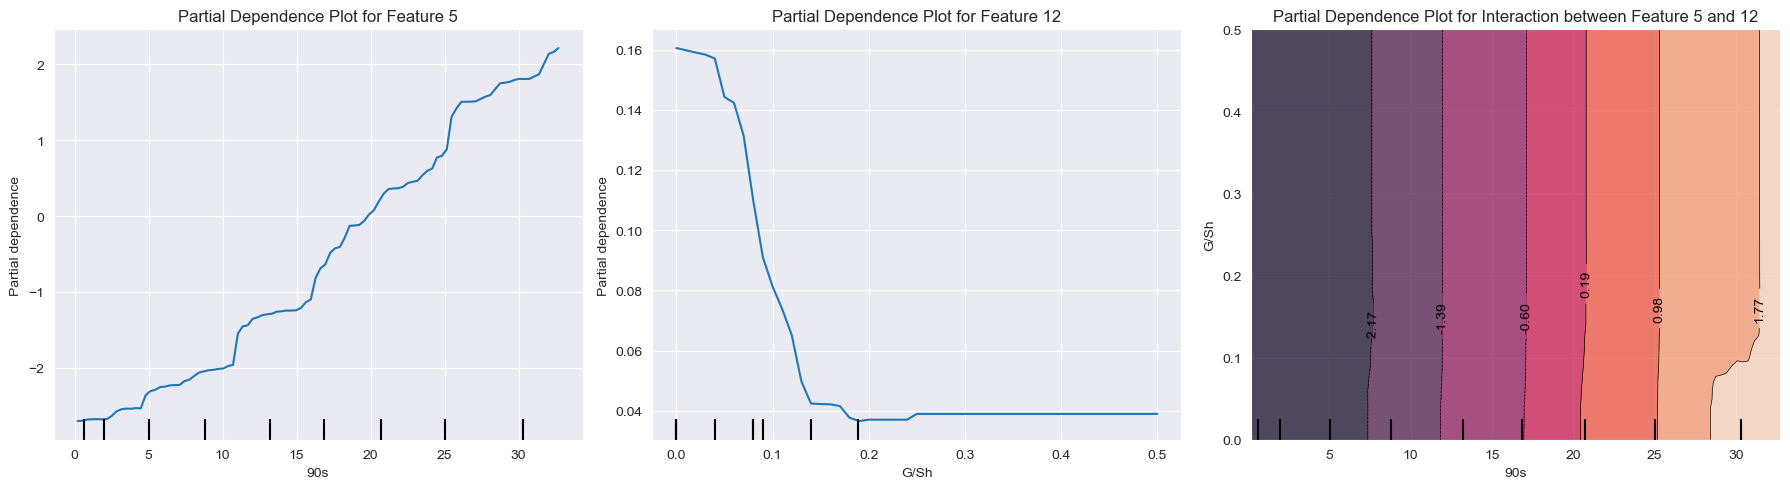

In [12]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

_, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

# Plot partial dependence for feature 5
PartialDependenceDisplay.from_estimator(best_model_2nd, X_test, features=[5], ax=ax[0])
ax[0].set_title('Partial Dependence Plot for Feature 5')

# Plot partial dependence for feature 12
PartialDependenceDisplay.from_estimator(best_model_2nd, X_test, features=[12], ax=ax[1])
ax[1].set_title('Partial Dependence Plot for Feature 12')

# Plot partial dependence for interaction between features 5 and 12
PartialDependenceDisplay.from_estimator(best_model_2nd, X_test, features=[(5, 12)], ax=ax[2])
ax[2].set_title('Partial Dependence Plot for Interaction between Feature 5 and 12')

plt.tight_layout()
plt.show()

# Apply Model to Test Data

## Load Data

In [ ]:
def load_data(file_path, encoding='cp949'):
    test_df = pd.read_csv(file_path, encoding=encoding)
    test_df.info()
    
    test_df = test_df.drop(['Rk'], axis=1)

    replace_values = {
        'DF,FW': 'FW,DF',
        'DF,MF': 'MF,DF',
        'MF,FW': 'FW,MF'
    }

    test_df['Pos'] = test_df['Pos'].replace(replace_values)
    
    # 'Age' 열에서 '-' 앞의 정보만 추출하여 새로운 열로 저장
    test_df['Age'] = test_df['Age'].str.split('-').str[0]

    # 숫자로 변환할 수 없는 값이 있는 경우 NaN으로 변경(object -> NaN)
    test_df['Age'] = pd.to_numeric(test_df['Age'], errors='coerce')
    
    return test_df

file_path = "../csv/LaLiga/2023-2024_La.csv"
laliga_test = load_data(file_path)

print(">>> Preprocessing data...")
laliga_test.info()

In [ ]:
def impute_values(df):
    global imputer
    
    numeric_laliga_test = df.select_dtypes(include=[np.number])
    col_names = numeric_laliga_test.columns

    imputer.fit(numeric_laliga_test)
    numeric_laliga_test = imputer.transform(numeric_laliga_test)

    numeric_laliga_test_df = pd.DataFrame(numeric_laliga_test, columns=col_names)

    df[col_names] = numeric_laliga_test_df.round(2)
    
    return df

laliga_test = impute_values(laliga_test)

# 열 별로 NaN 값이 있는지 확인
column_nan = laliga_test.isna().any()
print(column_nan)

In [ ]:
def calculate_defensive_score(df, weights):
    global scaler 
    
    scaled_features = scaler.fit_transform(df[list(weights.keys())])
    scaled_df = pd.DataFrame(scaled_features, columns=weights.keys())

    # 종합 점수 계산
    df['Defensive Score'] = (
        scaled_df['Won'] * weights['Won'] +
        scaled_df['Lost'] * weights['Lost'] +
        scaled_df['Won%'] * weights['Won%'] +
        scaled_df['Tkl'] * weights['Tkl'] +
        scaled_df['TklW'] * weights['TklW'] +
        scaled_df['Def 3rd'] * weights['Def 3rd'] +
        scaled_df['Mid 3rd'] * weights['Mid 3rd'] +
        scaled_df['Att 3rd'] * weights['Att 3rd']
    )
    return df

# 예시 사용
weights = {
    'Won': 1.0,
    'Lost': -0.5,
    'Won%': 1.5,
    'Tkl': 1.2,
    'TklW': 1.8,
    'Def 3rd': 1.5,
    'Mid 3rd': 1.0,
    'Att 3rd': 0.8
}

laliga_test = calculate_defensive_score(laliga_test, weights)

In [ ]:
def preprocess_data(df):
    global target_encoder
    
    X = df.drop(columns=['Player', 'Won', 'Lost', 'Won%', 'Tkl', 'TklW', 'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Defensive Score'], axis=1)
    y = df['Defensive Score']

    laliga_test_encoded = target_encoder.fit_transform(X, y)

    laliga_test_encoded['Defensive Score'] = df['Defensive Score']

    X_test = laliga_test_encoded.drop(columns=['Defensive Score'], axis=1)
    y_test = laliga_test_encoded['Defensive Score']
    
    return X_test, y_test

X_encoded_test, y_encoded_test = preprocess_data(laliga_test)

## 1st Model Test

In [ ]:
test_preds = best_model_1st.predict(X_encoded_test)
rmse = root_mean_squared_error(y_encoded_test, test_preds)
print(f'1st Random Forest evaluation by RMSE: {rmse:.2f}')
test_coef = best_model_1st.score(X_encoded_test, y_encoded_test)
print(f'1st Random Forest evaluation by coefficient: {test_coef:.2f}')

copied_X_test = X_encoded_test.copy()

copied_X_test['Predicted_Score'] = test_preds
max_predicted_index = copied_X_test['Predicted_Score'].idxmax()
predicted_defense_leader = laliga_test.loc[max_predicted_index, 'Player']

print(f'Defense Leader in the 23-24 season predicted by the model: {predicted_defense_leader}')

## 2nd Model Test

In [ ]:
from sklearn.metrics import root_mean_squared_error

test_preds = best_model_2nd.predict(X_encoded_test)
rmse = root_mean_squared_error(y_encoded_test, test_preds)
print(f'2nd Random Forest evaluation by RMSE: {rmse:.2f}')
test_coef = best_model_2nd.score(X_encoded_test, y_encoded_test)
print(f'2nd Random Forest evaluation by coefficient: {test_coef:.2f}')

copied_X_test = X_encoded_test.copy()

copied_X_test['Predicted_Score'] = test_preds
max_predicted_index = copied_X_test['Predicted_Score'].idxmax()
predicted_defense_leader = laliga_test.loc[max_predicted_index, 'Player']

print(f'Defense Leader in the 23-24 season predicted by the model: {predicted_defense_leader}')

# Premier League Test

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

class PremierLeagueDataProcessor:
    def __init__(self, file_path, encoding='cp949'):
        self.file_path = file_path
        self.encoding = encoding
        self.imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
        self.scaler = StandardScaler()
        self.target_encoder = ce.TargetEncoder(cols=['Nation', 'Pos', 'Squad', 'Matches'])
        self.df = None
        self.processed_data = None

    def load_data(self):
        self.df = pd.read_csv(self.file_path, encoding=self.encoding)
        self.df.info()
        self.df = self.df.drop(['Rk'], axis=1)
        
        replace_values = {
            'DF,FW': 'FW,DF',
            'DF,MF': 'MF,DF',
            'MF,FW': 'FW,MF'
        }
        self.df['Pos'] = self.df['Pos'].replace(replace_values)

        return self.df

    def impute_values(self):
        numeric_data = self.df.select_dtypes(include=[np.number])
        col_names = numeric_data.columns
        self.imputer.fit(numeric_data)
        imputed_data = self.imputer.transform(numeric_data)
        self.df[col_names] = pd.DataFrame(imputed_data, columns=col_names).round(2)
        
        return self.df

    def calculate_defensive_score(self, weights):
        scaled_features = self.scaler.fit_transform(self.df[list(weights.keys())])
        scaled_df = pd.DataFrame(scaled_features, columns=weights.keys())

        self.df['Defensive Score'] = (
            scaled_df['Won'] * weights['Won'] +
            scaled_df['Lost'] * weights['Lost'] +
            scaled_df['Won%'] * weights['Won%'] +
            scaled_df['Tkl'] * weights['Tkl'] +
            scaled_df['TklW'] * weights['TklW'] +
            scaled_df['Def 3rd'] * weights['Def 3rd'] +
            scaled_df['Mid 3rd'] * weights['Mid 3rd'] +
            scaled_df['Att 3rd'] * weights['Att 3rd']
        )
        
        return self.df

    def preprocess_data(self):
        X = self.df.drop(columns=['Player', 'Won', 'Lost', 'Won%', 'Tkl', 'TklW', 'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Defensive Score'], axis=1)
        y = self.df['Defensive Score']

        self.processed_data = self.target_encoder.fit_transform(X, y)
        self.processed_data = pd.DataFrame(self.processed_data, columns=X.columns)
        self.processed_data['Defensive Score'] = y.values

        X_test = self.processed_data.drop(columns=['Defensive Score'], axis=1)
        y_test = self.processed_data['Defensive Score']
        
        return X_test, y_test

    def evaluate_model(self, model, X_test, y_test):
        preds = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        score = model.score(X_test, y_test)
        
        return rmse, score

# Usage example
file_path = "../csv/2023-2024_Pre.csv"
processor = PremierLeagueDataProcessor(file_path)

processor.load_data()
processor.impute_values()
print(">>> Preprocessing data...")
processor.df.info()

weights = {
    'Won': 1.0,
    'Lost': -0.5,
    'Won%': 1.5,
    'Tkl': 1.2,
    'TklW': 1.8,
    'Def 3rd': 1.5,
    'Mid 3rd': 1.0,
    'Att 3rd': 0.8
}

processor.calculate_defensive_score(weights)

X_encoded_test, y_encoded_test = processor.preprocess_data()

## 1st Model Test

In [ ]:
test_preds = best_model_1st.predict(X_encoded_test)
rmse, test_coef = processor.evaluate_model(best_model_1st, X_encoded_test, y_encoded_test)

print(f'1st Random Forest evaluation by RMSE: {rmse:.2f}')
print(f'1st Random Forest evaluation by coefficient: {test_coef:.2f}')

copied_X_test = X_encoded_test.copy()

copied_X_test['Predicted_Score'] = test_preds
max_predicted_index = copied_X_test['Predicted_Score'].idxmax()
predicted_defense_leader = processor.df.loc[max_predicted_index, 'Player']

print(f'Defense Leader in the 23-24 season predicted by the model: {predicted_defense_leader}')

In [ ]:
test_preds = best_model_2nd.predict(X_encoded_test)
rmse, test_coef = processor.evaluate_model(best_model_2nd, X_encoded_test, y_encoded_test)

print(f'2nd Random Forest evaluation by RMSE: {rmse:.2f}')
print(f'2nd Random Forest evaluation by coefficient: {test_coef:.2f}')

copied_X_test = X_encoded_test.copy()

copied_X_test['Predicted_Score'] = test_preds
max_predicted_index = copied_X_test['Predicted_Score'].idxmax()
predicted_defense_leader = processor.df.loc[max_predicted_index, 'Player']

print(f'Defense Leader in the 23-24 season predicted by the model: {predicted_defense_leader}')